# FLX_JP-BBY
partition FLUXNET-CH4 data from Bibai bog into diffusive and ebullitive fluxes

In [1]:
import pandas as pd
import numpy as np
import pywt
import wavefuncs as wave
import plotter as p

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial as P

In [2]:
# global plotting settings
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') 

## Import data and process

In [3]:
df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame

In [4]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

plot entire FCH4 series vs time

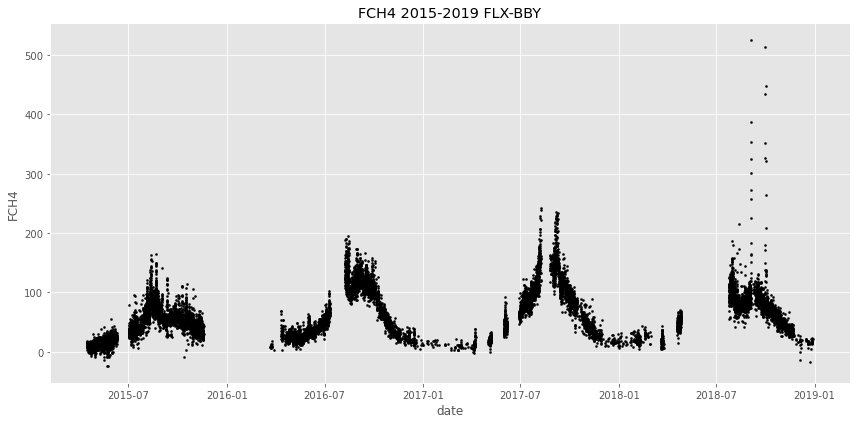

In [5]:
p.scatterdate(df.index, df['FCH4'], xlabel='date', ylabel='FCH4', title="FCH4 2015-2019 FLX-BBY")

ebullition ~2018-08?

In [6]:
dfw = df.loc['2018-07-01':'2019-01-01']

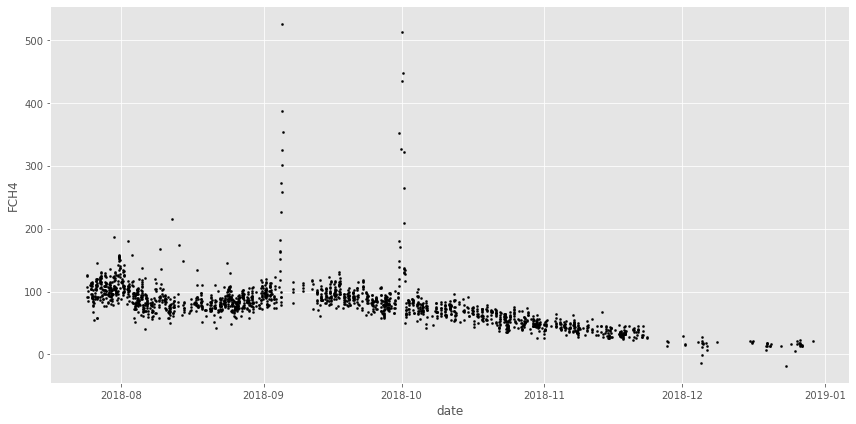

In [7]:
p.scatterdate(dfw.index, dfw['FCH4'], xlabel = 'date', ylabel = 'FCH4')

trim off Dec and sparse regions in Nov 

In [8]:
dfw = dfw.loc['2018-08-01':'2018-11-22']
dfw = dfw.loc[dfw['FCH4'].first_valid_index():dfw['FCH4'].last_valid_index()]
dfw.tail()

,TIMESTAMP_START,TIMESTAMP_END,NEE,H,LE,FCH4,USTAR,SW_IN,SW_OUT,LW_IN,...,G_F,WTD_F,WS_F,LE_F_ANNOPTLM,NEE_F_ANNOPTLM,FCH4_F_ANNOPTLM,FCH4_F_RANDUNC,FCH4_F_ANNOPTLM_UNC,FCH4_F_ANNOPTLM_QC,date
date,,,,,,,,,,,,,,,,,,,,,
2018-11-22 08:30:00,201811220830,201811220900,NaN,10.299,NaN,27.759,0.117947,162.733,30.072,250.470,...,-8.4635,-0.033667,1.173,8.881268,-0.002383,27.759,14.054628,NaN,1,2018-11-22 08:30:00
2018-11-22 09:00:00,201811220900,201811220930,0.24140,19.067,NaN,27.083,0.128069,220.863,30.408,264.760,...,-8.5348,-0.033667,1.492,12.958019,0.241400,27.083,13.862763,NaN,1,2018-11-22 09:00:00
2018-11-22 09:30:00,201811220930,201811221000,1.07490,51.908,44.564,44.661,0.154567,271.138,36.671,268.875,...,-8.5913,-0.033667,1.330,44.564000,1.074900,44.661,10.889463,NaN,1,2018-11-22 09:30:00
2018-11-22 10:00:00,201811221000,201811221030,0.37500,38.059,32.652,37.238,0.118917,221.318,23.119,287.204,...,-8.6442,-0.033333,1.470,32.652000,0.375000,37.238,10.391490,NaN,1,2018-11-22 10:00:00
2018-11-22 10:30:00,201811221030,201811221100,-0.44658,18.734,20.402,30.939,0.101577,159.709,12.566,293.984,...,-8.6673,-0.033333,1.075,20.402000,-0.446580,30.939,14.003261,NaN,1,2018-11-22 10:30:00


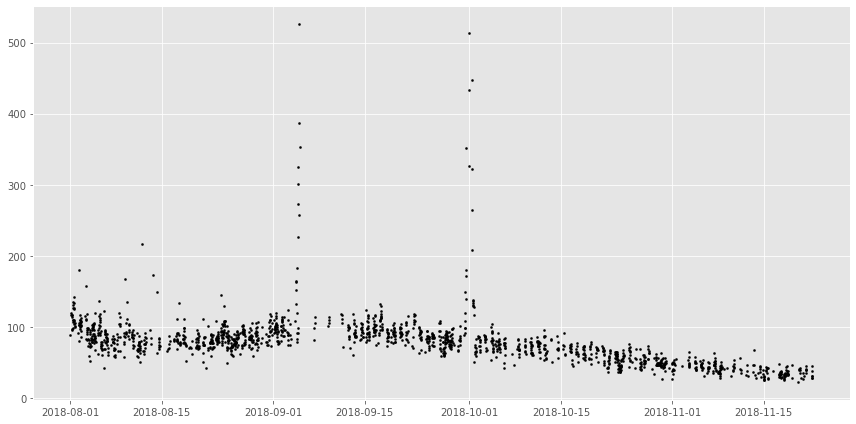

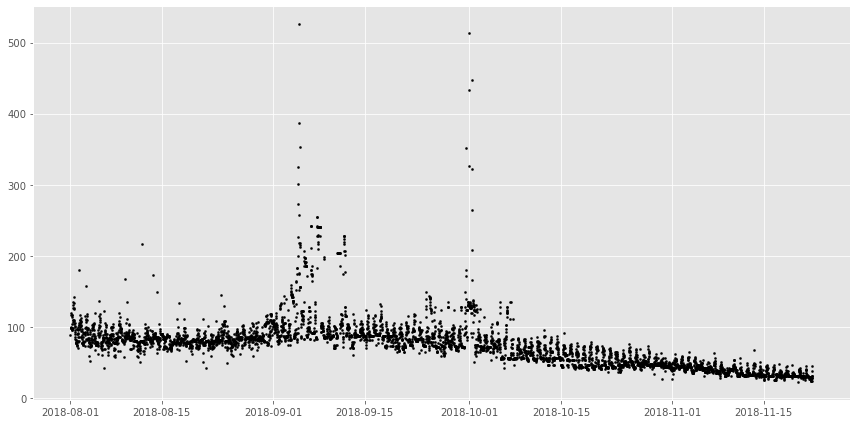

In [9]:
p.scatterdate(dfw.index, dfw['FCH4'])
p.scatterdate(dfw.index, dfw['FCH4_F'])

gap-filling adding some info after first big spike (~mid Sept), but I'll use it and see what happens

In [10]:
# normalize
nM, [xpM, ypM] = wave.norm(dfw.loc[:, 'FCH4_F'].to_numpy())
nLE, [xpLE, ypLE] = wave.norm(dfw.loc[:, 'LE_F'])
nT, [xpT, ypT] = wave.norm(dfw.loc[:, 'TA_F'])

In [11]:
# add normalized series to df
df.loc[dfw.index, 'FCH4_Fn'] = nM
df.loc[dfw.index, 'LE_Fn'] = nLE
df.loc[dfw.index, 'TA_Fn'] = nT

In [12]:
# compute wavelet coefficients using MODWT
[cM, cT, cLE] = wave.mra8(df.loc[dfw.index, ['FCH4_Fn', 'TA_Fn', 'LE_Fn']].to_numpy(), level=7, axis=0)

In [13]:
# sum wavelet scales and calculate scale windows
csumM, scalesM = wave.sum_scales(cM)
csumT, scalesT = wave.sum_scales(cT)
csumLE, scalesLE = wave.sum_scales(cLE)

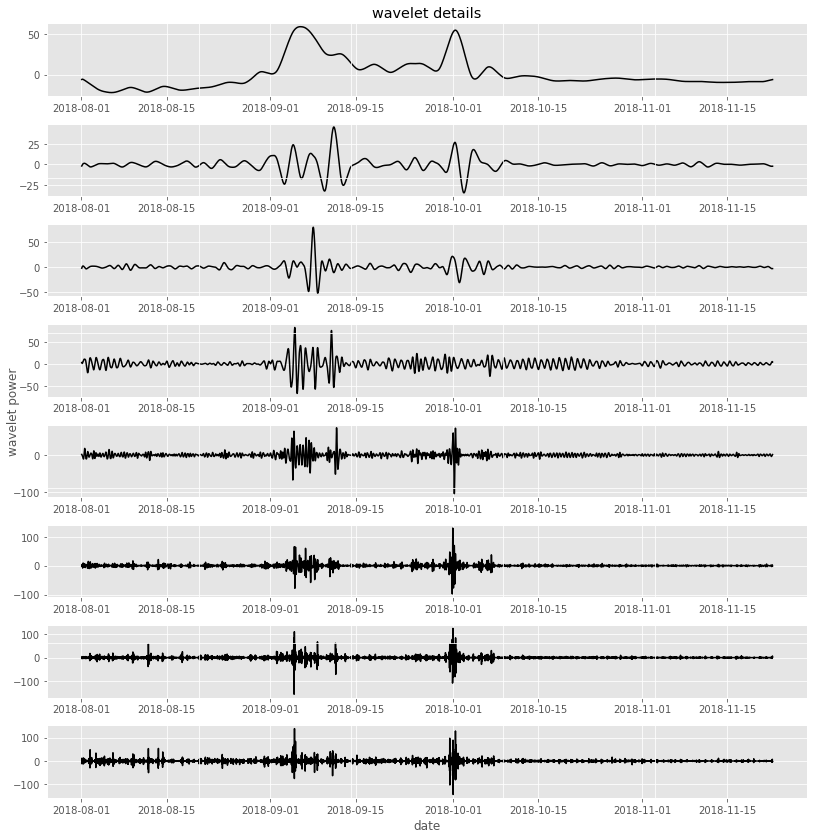

In [14]:
p.wavelet(dfw.index, cM)

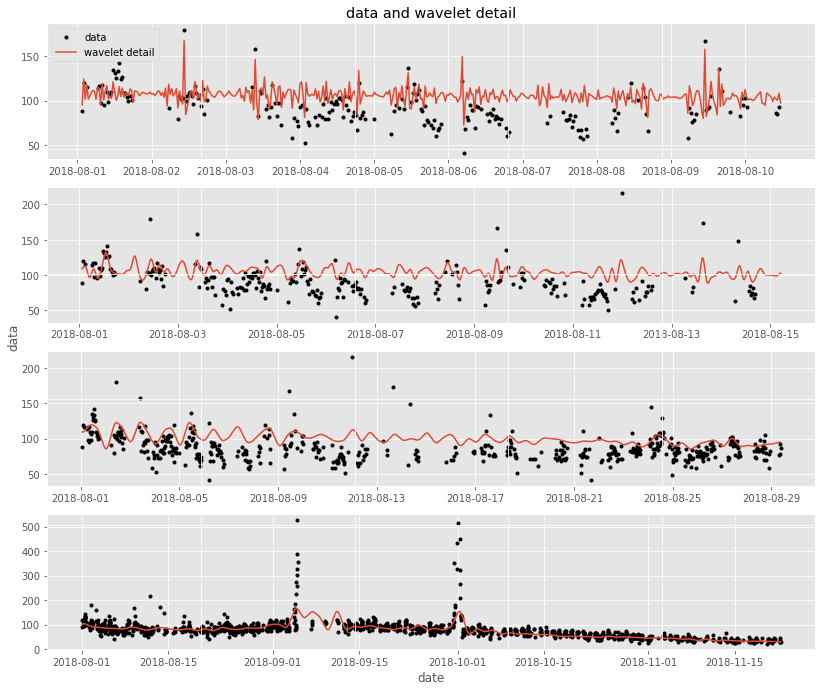

In [15]:
p.reconst(dfw.index, df.loc[dfw.index, 'FCH4'], csumM, scalesM, ypM, filename='20210528_wavedet_FCH4_BBY.jpeg')

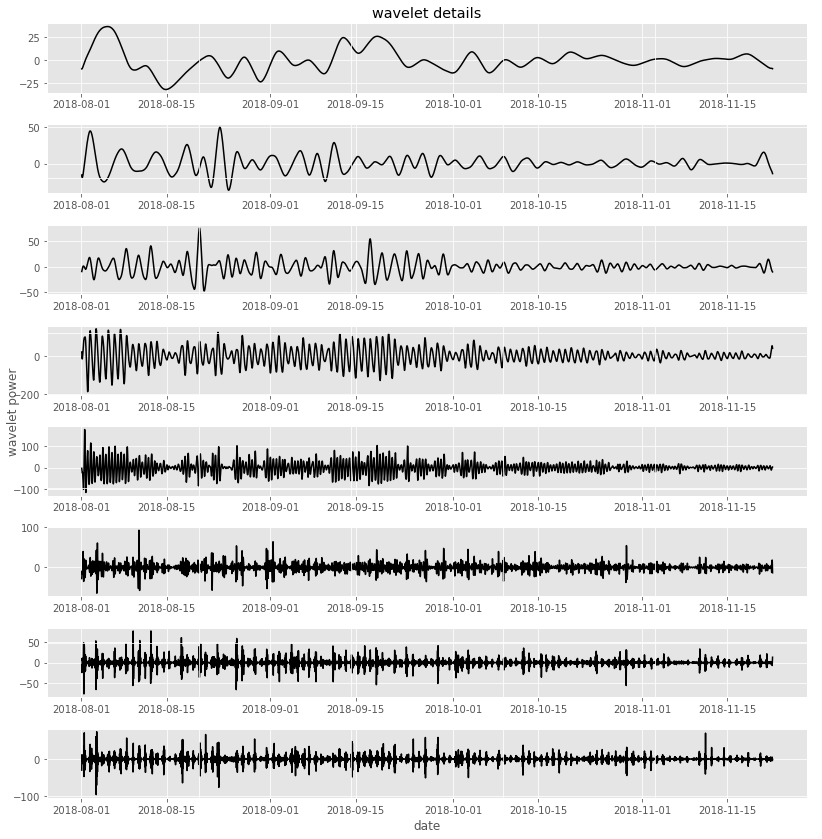

In [16]:
p.wavelet(dfw.index, cLE)

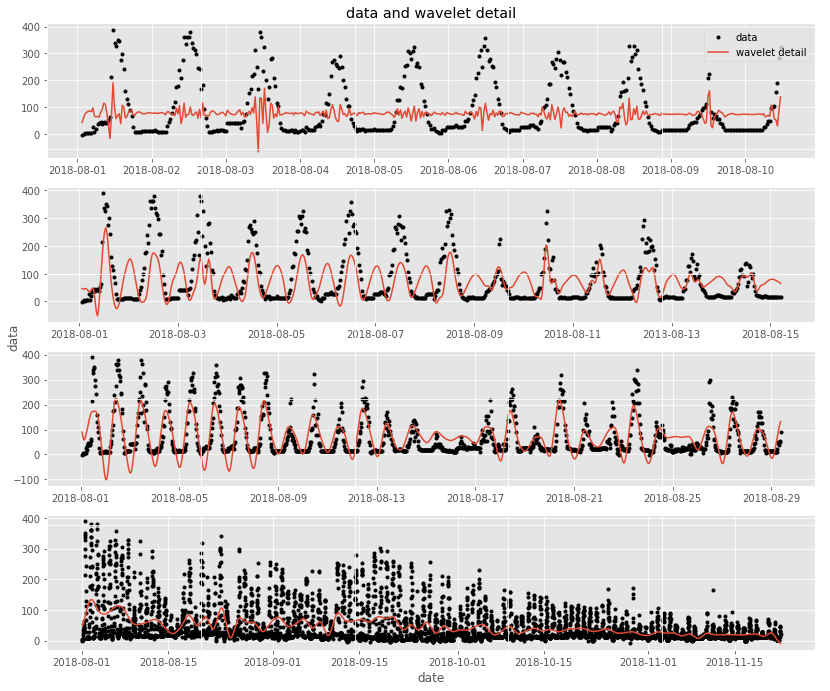

In [17]:
p.reconst(dfw.index, df.loc[dfw.index, 'LE_F'], csumLE, scalesLE, ypLE, filename='20210528_wavedet_LE_BBY.jpeg')

In [18]:
# flatten lists of wavelet coefficients
cM_flat = np.concatenate(csumM).ravel()
cLE_flat = np.concatenate(csumLE).ravel()

cMpd = pd.DataFrame(csumM).transpose()
cLEpd = pd.DataFrame(csumLE).transpose()

In [19]:
p_MvLE = P.fit(cM_flat, cLE_flat, 1)
xp, yp = p_MvLE.linspace(len(cMpd))

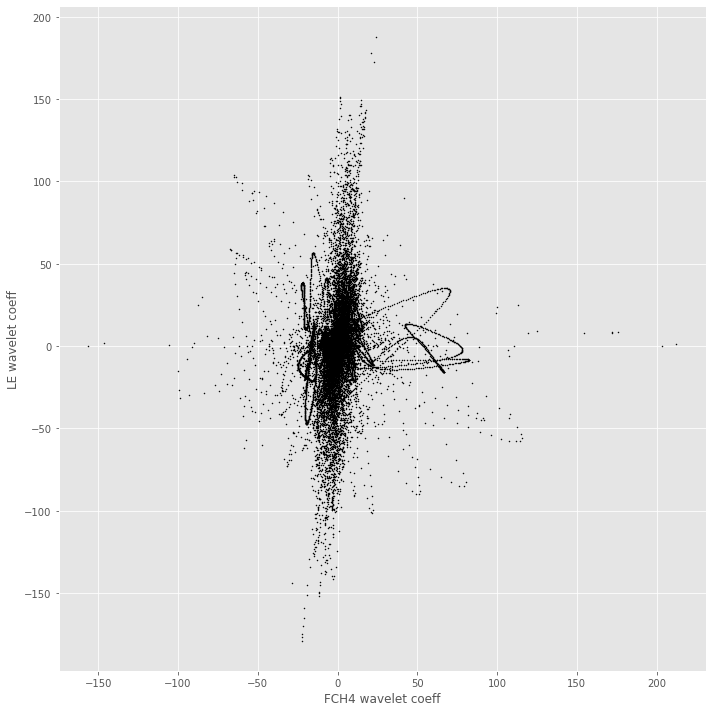

In [21]:
p.scattercoef(cM_flat, cLE_flat, xlabel='FCH4 wavelet coeff', ylabel='LE wavelet coeff', filename="20210528_wavecoeff_FCH4_LE_BBY.jpeg")